### This notebook imports paleo-data and their ages, reconstructs them according to several alternative specified plate models, and visualizes the empirical uncertainties on their reconstructed positions

In [1]:
import numpy as np
import pandas as pd
import pygplates as pygp
import matplotlib.pyplot as plt

#### User input: time range, paleo-data file, the plate models to be used, and some plotting variables

In [2]:
start = 5   # start time (in Ma) = youngest reconstruction step (not t=0)
stop = 195    # stop time (in Ma) = oldest reconstruction step
step = 10     # temporal step size (in Ma)

data_points = 'data/croc.csv'

plate_models = [                 # this list just provides short-hand labels to call the models
                'WR13',
                'MA16',
                'TC16',
                'SC16', 
                'ME21']

static_polygons = [
                   'plate_models/WR13/WR13_static_polygons.gpmlz',   # first static polygons file (corresponding to plate model #1)
                   'plate_models/MA16/MA16_static_polygons.gpmlz',   # second static polygons file (corresponding to plate model #2)
                   'plate_models/TC16/TC16_static_polygons.gpmlz',   # ...
                   'plate_models/SC16/SC16_static_polygons.gpmlz',   # ...
                   'plate_models/ME21/ME21_static_polygons.gpmlz']   # ...
                   
rotation_models = [
                   'plate_models/WR13/WR13_rotation_model.rot',     # first rotation file (corresponding to plate model #1)
                   'plate_models/MA16/MA16_rotation_model.rot',     # second rotation file (corresponding to plate model #2)
                   'plate_models/TC16/TC16_rotation_model.rot',     # ...
                   'plate_models/SC16/SC16_rotation_model.rot',     # ...
                   'plate_models/ME21/ME21_rotation_model.rot']     # ...
                   
anchor_plates = [                 # plate ID that corresponds to the desired reference frame
                 0,
                 0, 
                 1, 
                 0,
                 0]

plt_symbols = [
                '*',
                'P',
                'p',
                'o',
                'v']

plt_colors = [
                'red',
                'green',
                'orange',
                'purple',
                'blue']
               

#### Import paleo-data and build an associated dataframe for each plate model

In [3]:
df = {}
for mod in plate_models:
    df[mod] = pd.read_csv(data_points, header=0).dropna().reset_index(drop=True)                 # ignore empty lines
    df[mod]['pygp_pts'] = df[mod].apply(lambda row: pygp.PointOnSphere((row.lat, row.lng)), axis=1)   # convert lat/lons to pygplates point format and append as new column
    df[mod]['plt_id'] = np.nan        # plate id (to be assigned by partitioning step)
    df[mod]['maxage'] = np.nan        # maximum age of the reconstructable point (to be assigned by partitioning step)
    df[mod]['pygp_feature'] = np.nan  # bundled pygplates data (point, plate id and valid age)
    df[mod]['plt_id'] = df[mod]['plt_id'].astype('Int64') # this allows this column of NaNs to later be updated with ints

#### Assign plate IDs to each reference grid point according to each plate model

In [4]:
for i, mod in enumerate(plate_models):
    
    point_features = []
    for j in df[mod]['pygp_pts']:
        point_feature = pygp.Feature()
        point_feature.set_geometry(j)
        point_features.append(point_feature)

    partitioned_features = pygp.partition_into_plates(static_polygons[i], rotation_models[i], point_features,
                                                      properties_to_copy = [pygp.PartitionProperty.reconstruction_plate_id,
                                                                            pygp.PartitionProperty.valid_time_period],
                                                      sort_partitioning_plates=pygp.SortPartitioningPlates.by_plate_area)
    
    partitioned_data = []
    for j in partitioned_features:
        point = j.get_geometry()
        plt_id = j.get_reconstruction_plate_id()
        if plt_id == 0: plt_id = np.nan
        begin_time, end_time = j.get_valid_time()
        partitioned_data.append([point, plt_id, begin_time, j])
        
    for j in partitioned_data:
        idx = df[mod][(df[mod].pygp_pts == j[0]) & (pd.isnull(df[mod].pygp_feature))].index[0] 
        df[mod].loc[idx,['plt_id', 'maxage', 'pygp_feature']] = j[1], j[2], j[3]

#### Reconstruct points through time range according to each plate model and append to dataframe

In [5]:
df_rlats_max = pd.DataFrame(index=pd.RangeIndex(start=start, stop=stop+step, step=step))

for i, mod in enumerate(plate_models):
    
    lat_maxs = []
    for time in range(start, stop+step, step):
        reconstruct = df[mod].loc[(time-(step/2) < df[mod]['mid_ma']) & (time+(step/2) > df[mod]['mid_ma']) & (df[mod]['maxage'] >= time)
                                  & (df[mod]['plt_id'] != np.nan)].copy()  # for each timestep select subset of reconstructable points

        reconstructed_geometries = []
        pygp.reconstruct(reconstruct['pygp_feature'], rotation_models[i], reconstructed_geometries,
                         time, anchor_plate_id = anchor_plates[i])            # reconstruct points

        reconstructed_points = [x.get_reconstructed_geometry().to_lat_lon() for x in reconstructed_geometries]
        reconstructed_lats = [x[0] for x in reconstructed_points]
        reconstructed_lons = [x[1] for x in reconstructed_points]
        reconstruct[f'lat_{time}'] = reconstructed_lats
        reconstruct[f'lng_{time}'] = reconstructed_lons
        df[mod] = pd.concat([df[mod], reconstruct[f'lng_{time}'], reconstruct[f'lat_{time}']], axis=1, join='outer') # append reconstructed lat & lons back to dataframe
        
        df_lats = pd.DataFrame(reconstructed_lats)
        lat_maxs.append(df_lats.abs().max(numeric_only = True).values)
    
    df_rlats_max[f'lat_max_{mod}'] = lat_maxs 
    df_rlats_max[f'lat_max_{mod}'] = df_rlats_max[f'lat_max_{mod}'].str[0]

#### Plot the maximum absolute paleolatitude for each model for each time step

In [6]:
overall_max = df_rlats_max.max(axis=1)
overall_min = df_rlats_max.min(axis=1)

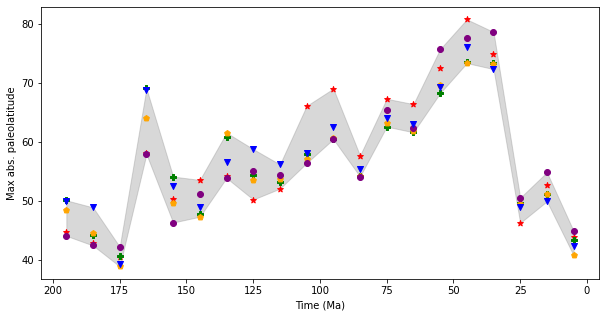

In [7]:
plt.figure(figsize=(10,5))
plt.fill_between(df_rlats_max.index, overall_max, overall_min, color='grey', alpha=0.3)

for i, mod in enumerate(plate_models):
    
    plt.scatter(df_rlats_max.index, df_rlats_max[f'lat_max_{mod}'], marker = plt_symbols[i], color = plt_colors[i])

plt.gca().invert_xaxis()
plt.xlabel('Time (Ma)')
plt.ylabel('Max abs. paleolatitude')
plt.show()

#### Plot the maximum absolute paleolatitude for each model for each time step

In [8]:
lat_cols = []
for time in range(start, stop+step, step): 
    lat_cols.append(f'lat_{time}')

df_rlats = {}
for i, mod in enumerate(plate_models):
    df_rlats[mod] = df[mod][lat_cols].copy()
    df_rlats[mod][f'avg_lat_{mod}'] = df_rlats[mod].mean(axis=1, numeric_only=True)
    df_rlats[mod] = df_rlats[mod].drop(columns = lat_cols)
    
merged = pd.concat(df_rlats, axis=1, keys=plate_models)    # collapse into single dataframe

In [9]:
df_avgs = pd.DataFrame()
df_avgs['max_lats'] = merged.max(axis=1, numeric_only=True)
df_avgs['med_lats'] = merged.median(axis=1, numeric_only=True)
df_avgs['min_lats'] = merged.min(axis=1, numeric_only=True)
df_avgs['counts'] = merged.count(axis=1, numeric_only=True)
df_avgs['age'] = df[plate_models[0]]['mid_ma']
df_avgs['lo_y_err'] = df_avgs['med_lats']-df_avgs['min_lats']
df_avgs['hi_y_err'] = df_avgs['max_lats']-df_avgs['med_lats']

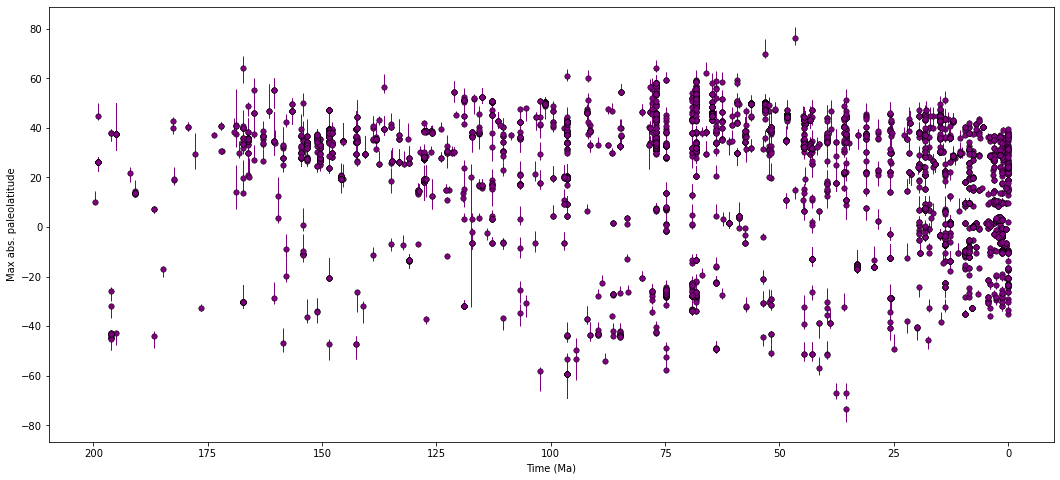

In [10]:
plt.figure(figsize=(18,8))
plt.errorbar(df_avgs['age'], df_avgs['med_lats'], yerr=((df_avgs['lo_y_err'], df_avgs['hi_y_err'])), 
             ls='none', ecolor='purple', elinewidth=1, zorder=0)
plt.scatter(df_avgs['age'], df_avgs['med_lats'], marker='o', s=30, 
            color='purple', edgecolor='black', linewidth=0.5, zorder=1)

plt.gca().invert_xaxis()
plt.xlabel('Time (Ma)')
plt.ylabel('Max abs. paleolatitude')
plt.show()